In [1]:
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import spacy
# Create CV training and test scores for various training set sizes
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import errno
import numpy
from torch.utils.data import DataLoader

torch.manual_seed(0)


def score_function(y_pred, y):
    predicted = y_pred.detach().argmax(axis=1)
    actual = y.numpy().argmax(axis=1)
    return f1_score(predicted, actual)


def vectorize(text, max_length):
    """
    Covert array of tokens, to array of ids, with a fixed length
    and zero padding at the end
    Args:
        text (): the wordlist
        word2idx (): dictionary of word to ids
        max_length ():
        unk_policy (): how to handle OOV words

    Returns: list of ids with zero padding at the end

    """
    words = numpy.zeros(max_length).astype(int)

    # trim tokens after max length
    text = text[:max_length]

    for i, token in enumerate(text):
        if token == 0:
            words[i] = 0
        else:
            words[i] = token
    return words


def train_epoch(_epoch, dataloader, model, loss_function, ev_tr):
    # switch to train mode -> enable regularization layers, such as Dropout
    if ev_tr == "train":
        model.train()
    else:
        model.eval()
    loss_score = []
    metric_score = []

    for sample_batched in dataloader:
        # get the inputs (batch)
        inputs, labels = sample_batched

        # 1 - zero the gradients
        optimizer.zero_grad()

        # 2 - forward pass: compute predicted y by passing x to the model
        outputs = model(inputs)
        # 3 - compute loss
        loss = loss_function(outputs, labels.float())
        loss.backward()

        # 5 - update weights
        optimizer.step()

        loss_score.append(loss.detach().item())
        metric_score.append(score_function(outputs, labels))
    print(ev_tr)
    print("loss", np.average(loss_score))
    print("score", np.average(metric_score))
    return np.average(loss_score), np.average(metric_score)


def replace_with_id(sentence, word2idx):
    id_sentence = []
    for word in nlp(sentence):
        if str(word) in word2idx:
            token_id = word2idx[str(word)]
        else:
            token_id = word2idx["<unk>"]
        id_sentence.append(token_id)
    return id_sentence


def text_to_df(data_path="SMSSpamCollection.txt"):
    print("morph data into a dataframe")
    with open(data_path, "r") as f:
        input_text = f.readlines()

    input_text = [(i.split("\t")[0], i.split("\t")[-1]) for i in input_text]
    df_data = pd.DataFrame(input_text, columns=["label", "sentence"])
    print("all data", df_data.shape)
    print("spam count", df_data.loc[df_data["label"] == "spam", :].shape[0])
    print("ham count", df_data.loc[df_data["label"] == "ham", :].shape[0])
    df_data["label"] = df_data["label"].apply(lambda x: 1 if x == "spam" else 0)
    return df_data


class CNNClassifier(nn.Module):

    def __init__(self, embeddings, kernel_dim=100, kernel_sizes=(3, 4, 5), output_size=2, trainable_emb=False):
        super(CNNClassifier, self).__init__()
        # input
        vocab_size = embeddings.shape[0]
        embedding_dim = embeddings.shape[1]
        #  end of inputs.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.init_embeddings(embeddings, trainable_emb)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)

    def forward(self, x):

        inputs = self.embedding(x)
        inputs = inputs.unsqueeze(1)
        inputs = [torch.relu(conv(inputs)).squeeze(3) for conv in self.convs]  # [(N,Co,W), ...]*len(Ks)
        inputs = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs]  # [(N,Co), ...]*len(Ks)
        concated = torch.cat(inputs, 1)
        out = self.fc(concated)
        return out

    def init_embeddings(self, weights, trainable):
        self.embedding.weight = nn.Parameter(weights, requires_grad=trainable)


class SampleDataset(Dataset):

    def __init__(self, x, y, max_length):
        self.data = x
        self.labels = y
        self.max_length = max_length

    def __getitem__(self, index):
        sample = vectorize(self.data[index], self.max_length)
        labels = torch.FloatTensor([1, 0]) if self.labels[index] == 1 else torch.FloatTensor([0, 1])
        return sample, labels

    def __len__(self):
        return len(self.data)


def load_word_vectors(file, dim):
    """
    Read the word vectors from a text file
    Args:
        file (): the filename
        dim (): the dimensions of the word vectors

    Returns:
        word2idx (dict): dictionary of words to ids
        idx2word (dict): dictionary of ids to words
        embeddings (numpy.ndarray): the word embeddings matrix

    """
    if os.path.exists(file):
        print('Indexing file {} ...'.format(file))

        word2idx = {}  # dictionary of words to ids
        idx2word = {}  # dictionary of ids to words
        embeddings = []  # the word embeddings matrix

        # create the 2D array, which will be used for initializing
        # the Embedding layer of a NN.
        # We reserve the first row (idx=0), as the word embedding,
        # which will be used for zero padding (word with id = 0).
        embeddings.append(numpy.zeros(dim))

        # read file, line by line
        with open(file, "r", encoding="utf-8") as f:
            for i, line in enumerate(f, 0):
                values = line.split(" ")
                word = values[0]
                vector = numpy.asarray(values[1:], dtype='float32')

                idx2word[i] = word
                word2idx[word] = i
                embeddings.append(vector)

            # add an unk token, for OOV words
            if "<unk>" not in word2idx:
                idx2word[len(idx2word) + 1] = "<unk>"
                word2idx["<unk>"] = len(word2idx) + 1
                embeddings.append(
                    numpy.random.uniform(low=-0.05, high=0.05, size=dim))

            print('Found %s word vectors.' % len(embeddings))
            embeddings = numpy.array(embeddings, dtype='float32')

        x = torch.from_numpy(embeddings).float()
        print("Normalize embeddings")
        x = x.div(x.norm(p=2, dim=1, keepdim=True))
        print("Normalizing ended")
        x[0] = 0
        return word2idx, idx2word, x

    else:
        print("{} not found!".format(file))
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), file)


morph data into a dataframe
all data (5574, 2)
spam count 747
ham count 4827
Indexing file glove.twitter.27B.200d.txt ...
Found 1193516 word vectors.
Normalize embeddings
Normalizing ended
epoch: 0
train
loss 0.3843749102618959
score 0.9191432162373789


eval
loss 0.16107865925878287
score 0.9678009222584718
epoch: 1
train
loss 0.07673043225788408
score 0.9870177108116314


eval
loss 0.04649233247877823
score 0.99394213530326
epoch: 2
train
loss 0.029344683937314483
score 0.9964017517064688


eval
loss 0.019305236011536584
score 0.997804556547059
epoch: 3
train
loss 0.012958972181917893
score 0.9989815891757132


eval
loss 0.008651249214178987
score 0.9997351118679344
epoch: 4
train
loss 0.006285917405815174
score 0.9998722860791827


eval
loss 0.004810211207303736
score 0.9998661311914323
epoch: 5
train
loss 0.004063163689958553
score 0.9998556998556999


eval
loss 0.0032776641422565768
score 0.999885452462772
epoch: 6
train
loss 0.002880868691459505
score 0.9998661311914323


eval
lo

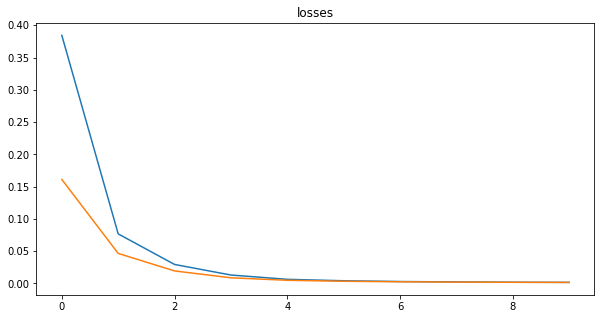

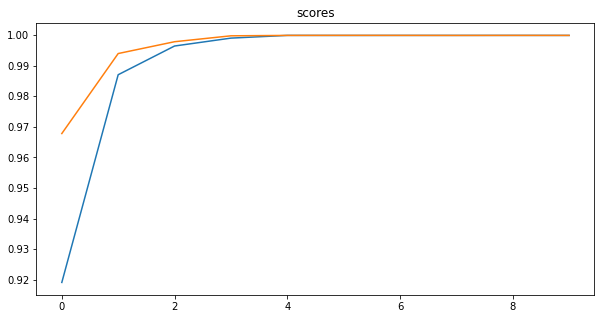

In [2]:
file = "glove.twitter.27B.200d.txt"
dim = 200
BATCH = 50
df = text_to_df(data_path="SMSSpamCollection.txt")
(word2idx, idx2word, embedding) = load_word_vectors(file, dim)

df["sentence"] = df["sentence"].apply(lambda x: x.lower())
nlp = spacy.load("en_core_web_sm")

df["sentence"] = df["sentence"].apply(lambda x: replace_with_id(x, word2idx))

X_train, X_test, y_train, y_test = train_test_split(df["sentence"].values, df["label"].values, test_size=0.2, random_state=42)


maximum_sentence_length = max([len(i) for i in X_train])
train_dataset = SampleDataset(X_train, y_train, maximum_sentence_length)
eval_dataset = SampleDataset(X_test, y_test, maximum_sentence_length)


train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

criterion = torch.nn.BCEWithLogitsLoss()
pretrained_embedding = embedding
EPOCHS = 10
trainable = False
lr = 0.001

model = CNNClassifier(pretrained_embedding)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)


train_losses = []
eval_losses = []

train_scores = []
eval_scores = []

for i in range(EPOCHS):
    print("epoch: %s" % i)
    train_loss, train_score = train_epoch(i, train_loader, model, criterion, "train")
    print("\n")
    eval_loss, eval_score = train_epoch(i, train_loader, model, criterion, "eval")

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

    train_scores.append(train_score)
    eval_scores.append(eval_score)

plt.figure(figsize=(10, 5))
plt.title("losses")
plt.plot(train_losses)
plt.plot(eval_losses)
plt.show()

plt.figure(figsize=(10, 5))
plt.title("scores")
plt.plot(train_scores)
plt.plot(eval_scores)
plt.show()